In [1]:
# import time
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
import matplotlib.pyplot as plt
from IPython.display import Audio, display
#from pydub import AudioSegment
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import os.path
from os import path
import os
import soundfile as sf
# import torchaudio.functional as F
# import torchaudio.transforms as T
import librosa
from tqdm.notebook import tqdm

print(torch.__version__)
print(torchaudio.__version__)

C:\Users\lejuj\Anaconda3\envs\torchaudio\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


1.8.1
0.8.1


In [23]:
!nvidia-smi 

Thu Apr 01 09:58:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 452.06       Driver Version: 452.06       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P5    12W /  N/A |    637MiB /  6144MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [3]:
# implement mixed precision

# panda time

In [2]:
tracks = pd.read_csv('data/fma_metadata/tracks.csv', index_col=0, header=[0, 1])
subset=tracks.index[tracks['set', 'subset'] == 'small']
tracks=tracks.loc[subset]
tracks;

## split dataset (train, test)

In [3]:
# train => track_id train 
# data => track_id + label
train_index = tracks.index[tracks['set', 'split'] == 'training']
val_index = tracks.index[tracks['set', 'split'] == 'validation']
test_index = tracks.index[(tracks['set', 'split'] == 'test' )| (tracks['set', 'split']=='validation') ]
print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train_index, val_index, test_index])))
genres = list(LabelEncoder().fit(tracks['track', 'genre_top']).classes_)
print('Top genres ({}): {}'.format(len(genres), genres))
data=tracks['track', 'genre_top']
# data,train_index[0], data.loc[train_index[0]] # (2, 'Hip-Hop')

6400 training examples, 800 validation examples, 1600 testing examples
Top genres (8): ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


In [4]:
enc = MultiLabelBinarizer()
labels = tracks['track', 'genres_all']
#labels = tracks['track', 'genres']
test_multi_index = tracks.index[(tracks['set', 'split'] == 'test' ) ]

# Split in training, validation and testing sets.
y_train = enc.fit_transform(labels[train_index])
y_val = enc.transform(labels[val_index])
y_test = enc.transform(labels[test_index])
# X_train = features.loc[train, columns].as_matrix()
# X_val = features.loc[val, columns].as_matrix()
# X_test = features.loc[test, columns].as_matrix()

/!\ data corrupted delete them : "099134.mp3" "108925.mp3" "133297.mp3" use cell below

In [5]:
#beug fix that
flag=len(train_index)
for i in range(len(train_index)):
    if flag==i:
        break
    if str(train_index[i])=="99134" or str(train_index[i])=="108925" or str(train_index[i])=="133297":
        print(i)
        train_index=train_index.delete(i)
        y_train=np.delete(y_train, i,axis=0)

        flag=flag-1


3530
3896
5609


## (use one time) to convert all mp3 to wav (more than 10 to 100 times faster with wav)

#!mkdir "data_proces/fma_small/"
path1="data/fma_small/"
path_stockage="data_proces/fma_small/"
count=0
for root, dirs, files in os.walk(path1):
    for name in files:
        if name.endswith(".mp3"):
            if not(path.exists(path_stockage+name[:-4]+'.wav')):
                try:
                    waveform, sample_rate=librosa.load(root+"/"+name,duration=15,sr=22050)
                    sf.write(path_stockage+name[:-4]+'.wav', waveform, sample_rate)
                    count+=1
                except:
                    print("audio :"+root+"/"+name+"  is corrupted")

# creation of dataset and dataloader

In [6]:
from torch.utils.data import Dataset, DataLoader

# creation of torch dataset


#type_set= train or test 
#audio_ids
label_dic = {'Electronic': 0,  'Experimental':1, 'Folk':2,'Hip-Hop':3,
 'Instrumental':4,
 'International':5,
 'Pop':6,
 'Rock':7}


class Audio_classification(Dataset):
    def __init__(self,type_set, audio_idx, class_ids,label_dic,time_audio_resize=3, transform = None):#("train",train,data,)
            self.type_set=type_set
            self.audio_ids = audio_idx
            self.class_ids = class_ids
            self.label_dic = label_dic
            self.time_audio_resize=time_audio_resize
            self.transform = transform
#             if self.is_valid == 1:
#                 self.aug = # transfoms for validation images
#             else:                  
#                 self.aug = # transfoms for training images
                
    def __len__(self):
          return len(self.audio_ids)
    
        
    def __getitem__(self, index):
            #on prend 3s
            load_first_n_sec_audio=15
            sample_rate_default=22050
            #time_audio_resize #= 3#sec
            
            #audio_path is like 000002.wav but self.audio_ids[index] has not all the 0 include so ...
            idx=self.audio_ids[index]
            count=len(str(idx))
            #print("The number of digits in the number are:",count)
            if count!=6:
                idx="0"*(6-count)+str(idx)
            audio_path=str(idx)

            filename = "data_proces/fma_small/"+ audio_path +".wav"
            label = self.label_dic[self.class_ids.loc[self.audio_ids[index]]]
            
            #load audio mp3
            
            waveform, sample_rate=torchaudio.load(filename, normalize = True)
            #waveform, sample_rate=sf.read(filename,sr=None)
                
            len_audio_resize = int(sample_rate_default * self.time_audio_resize)
            indice_max=len(waveform[0])-len_audio_resize-1
            indice_initial=np.random.randint(max(indice_max,1))
            #make 3sec long audio (time_audio_resize=3sec)
            if self.type_set=="train":
                waveform = waveform[:,indice_initial:indice_initial+len_audio_resize]
            else:
                waveform = waveform[:,0:len_audio_resize]
                
            # if weveform is to short zero padding at the end 
            if waveform.size()!=(1,len_audio_resize):
                waveform=torch.cat((waveform,torch.zeros((1,len_audio_resize-waveform.size(1)))),1)

            if self.transform:
                waveform = self.transform(waveform)
            return waveform,torch.tensor(label, dtype = torch.float)

        


# train and test function

In [163]:
#https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html
use_amp = False #mixed precision float 16
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

def train(model, device, trainloader, criterion, optimizer, epoch,scheduler, log_interval,grad_clip=None):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=use_amp): # full mixed precision enabled=use_amp   
            output = model(data)
            loss = criterion(output, target.long())
        scaler.scale(loss).backward()
        if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
#         loss.backward()
#         optimizer.step()
        train_loss += loss.item()
#     if batch_idx % log_interval == 0:
    print('Train Epoch: {}  \tLoss: {:.6f}   Accuracy: {}/{} ({:.0f}%'.format(
        epoch, loss.item(), correct, len(trainloader.dataset), 100. * correct / len(trainloader.dataset)))
    return train_loss/len(trainloader.dataset),100. * correct / len(trainloader.dataset)


def test(model, device, testloader,criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target.long()).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testloader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return test_loss,100. * correct / len(testloader.dataset)

# Model

## dataset waveform

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainset  = Audio_classification("train",train_index,data,label_dic)
trainloader  = DataLoader(trainset , batch_size=64,
                        shuffle=False, num_workers=0)

testset = Audio_classification("test",test_index,data,label_dic)
testloader   = DataLoader(testset , batch_size=64,
                        shuffle=False, num_workers=0)

wav,lab=trainset[0]
size_in=wav.size(1)
# size_in=sample['waveform'].size(1)
size_in

66150

## Baseline

In [9]:
class Model(nn.Module):
    def __init__(self,size_in):
        super(Model, self).__init__()
        self.size_in=size_in
        self.fc1 = nn.Linear(size_in, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 8)

    def forward(self, x):
        x = x.view(-1, self.size_in)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model

# from torchsummary import summary

# summary(model, ([1, size_in]))

In [15]:
#use cuda si possible
# model init
model = Model(size_in).to(device)
#loss = softmax + nllloss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
Train_loss=[]
Test_loss=[]
Train_acc= []
Test_acc=[]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 1  	Loss: 2.019386   Accuracy: 1460/6397 (23%

Test set: Average loss: 0.0304, Accuracy: 351/1600 (22%)



  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 2  	Loss: 1.978918   Accuracy: 1544/6397 (24%

Test set: Average loss: 0.0304, Accuracy: 347/1600 (22%)



  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 3  	Loss: 1.963755   Accuracy: 1499/6397 (23%

Test set: Average loss: 0.0304, Accuracy: 349/1600 (22%)



  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 4  	Loss: 2.021659   Accuracy: 1506/6397 (24%

Test set: Average loss: 0.0304, Accuracy: 347/1600 (22%)



  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 5  	Loss: 1.999352   Accuracy: 1519/6397 (24%

Test set: Average loss: 0.0304, Accuracy: 364/1600 (23%)



  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 6  	Loss: 1.985306   Accuracy: 1481/6397 (23%

Test set: Average loss: 0.0303, Accuracy: 360/1600 (22%)



  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 7  	Loss: 2.015974   Accuracy: 1491/6397 (23%

Test set: Average loss: 0.0303, Accuracy: 359/1600 (22%)



  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 8  	Loss: 1.995072   Accuracy: 1539/6397 (24%

Test set: Average loss: 0.0303, Accuracy: 365/1600 (23%)



  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 9  	Loss: 1.933881   Accuracy: 1511/6397 (24%

Test set: Average loss: 0.0303, Accuracy: 370/1600 (23%)



  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 10  	Loss: 1.989945   Accuracy: 1522/6397 (24%

Test set: Average loss: 0.0303, Accuracy: 374/1600 (23%)



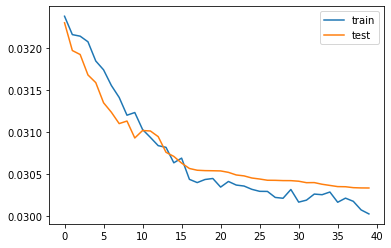

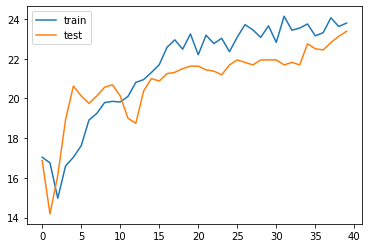

In [19]:
# best acc is 25% after 30 epochs
epochs=10
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001, steps_per_epoch=len(trainloader), epochs=epochs)

for epoch in range(1, epochs + 1):
    train_loss,train_acc=train(model, device, trainloader, criterion, optimizer, epoch,scheduler,log_interval=100)
    test_loss,test_acc=test(model, device, testloader,criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Train_acc.append(train_acc)
    Test_acc.append(test_acc)
plt.plot(Train_loss)
plt.plot(Test_loss)
plt.legend(["train","test"])
plt.show()
plt.plot(Train_acc)
plt.plot(Test_acc)
plt.legend(["train","test"])
plt.show()

In [13]:
Train_loss

[(0.03247521380921985, 13.615757386274817),
 (0.03227808683463069, 14.303579803032672),
 (0.03212598541555543, 14.803814287947475),
 (0.03188480685348714, 16.570267312802876),
 (0.031567705130416825, 17.945912146318587),
 (0.0315299689331818, 17.883382835704236),
 (0.03140983151815563, 18.164764733468814),
 (0.031170931573545484, 19.212130686259183),
 (0.030952744545816573, 20.68156948569642),
 (0.030944689337268405, 20.90042207284665)]

## model 1

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, 80, 4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.avgPool = nn.AvgPool1d(30) #input should be 512x30 so this outputs a 512x1
        self.fc1 = nn.Linear(1024, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = self.avgPool(x)
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        return x

# model = Net()
# model.to(device)
# print(model)

# from torchsummary import summary
# summary(model, ([1, size_in]))

In [ ]:
#use cuda si possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model init
model = Net().to(device)
#loss = softmax + nllloss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
Train_loss=[]
Test_loss=[]

In [ ]:
# best acc is 25%
epochs=8
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001, steps_per_epoch=len(trainloader), epochs=epochs)
for epoch in range(1, epochs + 1):
    train_loss=train(model, device, trainloader, criterion, optimizer, epoch,scheduler,log_interval=100)
    test_loss=test(model, device, testloader,criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
plt.plot(Train_loss)
plt.plot(Test_loss)
plt.legend(["train","test"])

In [ ]:
path="model_save/Net.pth"

torch.save(model.state_dict(), path)


In [ ]:
model = Net().to(device)(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()

## model 2

In [10]:
def conv_bn(in_channels, out_channels, kernel_size, same_padd=False, stride=1):
    if same_padd:
        return nn.Sequential(nn.Conv1d(in_channels, out_channels,kernel_size, stride,int((kernel_size-1)/2)), nn.BatchNorm1d(out_channels),nn.ReLU())
    else:
        return nn.Sequential(nn.Conv1d(in_channels, out_channels,kernel_size, stride), nn.BatchNorm1d(out_channels),nn.ReLU())
    
# arXiv:1603.05027v3,2016 un peu comme les resnetxl
class ResBlock(nn.Module):
    def __init__(self, in_channels, max_channels):
        super().__init__()
        self.in_channels, self.max_channels = in_channels, max_channels
        
        self.first_bn=nn.BatchNorm1d(self.in_channels)
        self.cbn1=conv_bn(self.in_channels,self.max_channels,1)
        self.cbn2=conv_bn(self.max_channels,self.max_channels,9,same_padd=True)
        self.c3=nn.Conv1d(self.max_channels,self.in_channels,1)
        self.last_bn=nn.BatchNorm1d(self.in_channels)
    def forward(self, x):
        residual = x
        x=self.first_bn(x)
        x=self.cbn1(x)
        x=self.cbn2(x)
        x=self.c3(x)
        x += residual
        x=self.last_bn(x)
        return x

In [11]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv0 = nn.Sequential(conv_bn(1,512,100,stride=20),nn.Conv1d(512, 512,20, 4))
        self.resblock1 = ResBlock(512,512)
        self.cbn1=conv_bn(512,512,4)
        self.pool1 = nn.MaxPool1d(4)
        self.resblock2 = ResBlock(512,256)
        self.cbn2=conv_bn(512,256,4)
        self.pool2 = nn.MaxPool1d(4)
        self.resblock3 = ResBlock(256,256)
        self.cbn3=conv_bn(256,128,10,stride=2)
        self.pool3 = nn.MaxPool1d(4)
        self.cbn4=conv_bn(128,100, 5)
        self.fc1 = nn.Linear(100, 64)
        self.fc2 = nn.Linear(64, 10)
        
        
    def forward(self, x):
        x = self.conv0(x)
        x = self.resblock1(x)
        x = self.cbn1(x)
        x = self.pool1(x)
        x = self.resblock2(x)
        x = self.cbn2(x)
        x = self.pool2(x)
        x = self.resblock3(x)
        x = self.cbn3(x)
        x = self.pool3(x)
        x = self.cbn4(x)
        x=x.view(x.size(0),-1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        return x
#         x = F.relu(self.bn2(x))
#         x = self.pool2(x)
#         x = self.conv3(x)
#         x = F.relu(self.bn3(x))
#         x = self.pool3(x)
#         x = self.conv4(x)
#         x = F.relu(self.bn4(x))
#         x = self.pool4(x)
#         x = self.avgPool(x)
#         x = x.view(x.size(0),-1)
#         x = self.fc1(x)
        
model = Net2().to(device)
# model
# print(model)

from torchsummary import summary
summary(model, ([1, size_in]))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 821]            --
|    └─Sequential: 2-1                   [-1, 512, 3303]           --
|    |    └─Conv1d: 3-1                  [-1, 512, 3303]           51,712
|    |    └─BatchNorm1d: 3-2             [-1, 512, 3303]           1,024
|    |    └─ReLU: 3-3                    [-1, 512, 3303]           --
|    └─Conv1d: 2-2                       [-1, 512, 821]            5,243,392
├─ResBlock: 1-2                          [-1, 512, 821]            --
|    └─BatchNorm1d: 2-3                  [-1, 512, 821]            1,024
|    └─Sequential: 2-4                   [-1, 512, 821]            --
|    |    └─Conv1d: 3-4                  [-1, 512, 821]            262,656
|    |    └─BatchNorm1d: 3-5             [-1, 512, 821]            1,024
|    |    └─ReLU: 3-6                    [-1, 512, 821]            --
|    └─Sequential: 2-5                   [-1, 512, 821]     

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 821]            --
|    └─Sequential: 2-1                   [-1, 512, 3303]           --
|    |    └─Conv1d: 3-1                  [-1, 512, 3303]           51,712
|    |    └─BatchNorm1d: 3-2             [-1, 512, 3303]           1,024
|    |    └─ReLU: 3-3                    [-1, 512, 3303]           --
|    └─Conv1d: 2-2                       [-1, 512, 821]            5,243,392
├─ResBlock: 1-2                          [-1, 512, 821]            --
|    └─BatchNorm1d: 2-3                  [-1, 512, 821]            1,024
|    └─Sequential: 2-4                   [-1, 512, 821]            --
|    |    └─Conv1d: 3-4                  [-1, 512, 821]            262,656
|    |    └─BatchNorm1d: 3-5             [-1, 512, 821]            1,024
|    |    └─ReLU: 3-6                    [-1, 512, 821]            --
|    └─Sequential: 2-5                   [-1, 512, 821]     

In [12]:
model = Net2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
Train_loss=[]
Test_loss=[]
Train_correct=[]
Test_correct=[]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 1  	Loss: 99.000000   Accuracy: 2.5246670246124268/3279 (6397%

Test set: Average loss: 0.0450, Accuracy: 325/800 (41%)

7.658192103303785e-06


  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 2  	Loss: 99.000000   Accuracy: 2.4444470405578613/3292 (6397%

Test set: Average loss: 0.0450, Accuracy: 331/800 (41%)

9.485192531172957e-06


  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 3  	Loss: 99.000000   Accuracy: 2.2208595275878906/3266 (6397%

Test set: Average loss: 0.0450, Accuracy: 325/800 (41%)

6.068821499737474e-06


  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 4  	Loss: 99.000000   Accuracy: 2.376798629760742/3321 (6397%

Test set: Average loss: 0.0451, Accuracy: 324/800 (40%)

1.8476211394223118e-06


  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 5  	Loss: 99.000000   Accuracy: 2.316194772720337/3336 (6397%

Test set: Average loss: 0.0452, Accuracy: 322/800 (40%)

2.414183399679499e-10


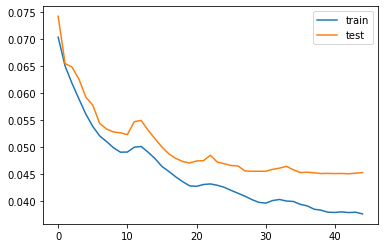

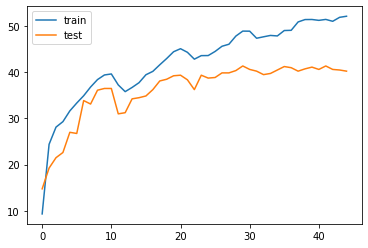

In [19]:

epochs=5
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.00001, steps_per_epoch=len(trainloader), epochs=epochs)
for epoch in range(1, epochs + 1):
    train_loss,correct_train=train(model, device, trainloader, criterion, optimizer, epoch,scheduler,log_interval=100)
    test_loss,correct_test=test(model, device, testloader,criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Train_correct.append(correct_train)
    Test_correct.append(correct_test)
    print(optimizer.param_groups[0]['lr'])

plt.plot(Train_loss)
plt.plot(Test_loss)
plt.legend(["train","test"])
plt.show()
plt.plot(Train_correct)
plt.plot(Test_correct)
plt.legend(["train","test"])
plt.show()

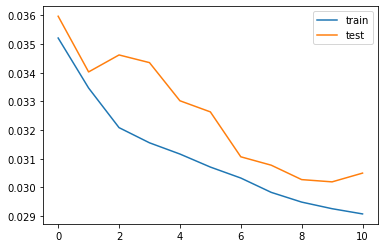

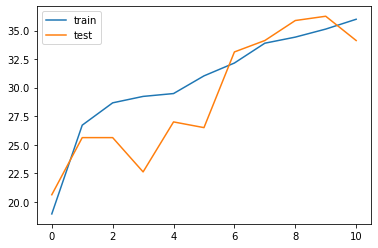

In [24]:
plt.plot(Train_loss)
plt.plot(Test_loss)
plt.legend(["train","test"])
plt.show()
plt.plot(Train_correct)
plt.plot(Test_correct)
plt.legend(["train","test"])
plt.show()

In [17]:
path="model_save/resnet_like_2.pth"

torch.save(model.state_dict(), path)

## model 3

In [28]:
import torchvision.models as models
from torchsummary import summary


In [68]:
model = Net_res().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
Train_loss=[]
Test_loss=[]
Train_correct=[]
Test_correct=[]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 1  	Loss: 1.608091   Accuracy: 2403/6397 (38%

Test set: Average loss: 0.0303, Accuracy: 248/800 (31%)

5.629147228973798e-05


  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 2  	Loss: 1.617767   Accuracy: 2281/6397 (36%

Test set: Average loss: 0.0317, Accuracy: 236/800 (30%)

0.00015258117466081583


  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 3  	Loss: 1.751310   Accuracy: 2229/6397 (35%

Test set: Average loss: 0.0313, Accuracy: 212/800 (26%)

0.00019999899290322893


  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 4  	Loss: 1.706410   Accuracy: 2302/6397 (36%

Test set: Average loss: 0.0315, Accuracy: 219/800 (27%)

0.00018990129390569822


  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 5  	Loss: 1.629497   Accuracy: 2342/6397 (37%

Test set: Average loss: 0.0314, Accuracy: 229/800 (29%)

0.00016199762030803588


  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 6  	Loss: 1.609946   Accuracy: 2386/6397 (37%

Test set: Average loss: 0.0307, Accuracy: 244/800 (30%)

0.00012181463688235772


  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 7  	Loss: 1.572996   Accuracy: 2427/6397 (38%

Test set: Average loss: 0.0316, Accuracy: 239/800 (30%)

7.731107630807018e-05


  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 8  	Loss: 1.547207   Accuracy: 2427/6397 (38%

Test set: Average loss: 0.0305, Accuracy: 234/800 (29%)

3.730141455726317e-05


  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 9  	Loss: 1.532206   Accuracy: 2505/6397 (39%

Test set: Average loss: 0.0296, Accuracy: 263/800 (33%)

9.710055825984118e-06


  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 10  	Loss: 1.594837   Accuracy: 2704/6397 (42%

Test set: Average loss: 0.0296, Accuracy: 265/800 (33%)

1.8070967710739916e-09


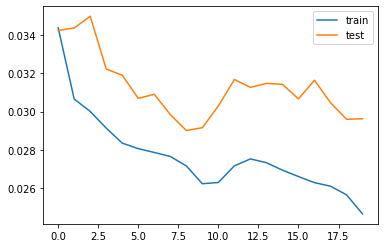

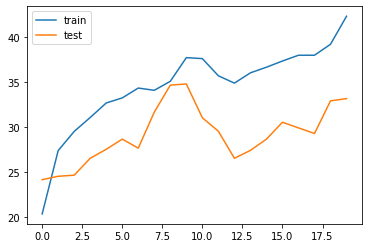

In [70]:

epochs=10
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0002, steps_per_epoch=len(trainloader), epochs=epochs)
for epoch in range(1, epochs + 1):
    train_loss,correct_train=train(model, device, trainloader, criterion, optimizer, epoch,scheduler,log_interval=100)
    test_loss,correct_test=test(model, device, testloader,criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Train_correct.append(correct_train)
    Test_correct.append(correct_test)
    print(optimizer.param_groups[0]['lr'])

plt.plot(Train_loss)
plt.plot(Test_loss)
plt.legend(["train","test"])
plt.show()
plt.plot(Train_correct)
plt.plot(Test_correct)
plt.legend(["train","test"])
plt.show()

In [ ]:
path="model_save/resnet_34.pth"

torch.save(model.state_dict(), path)